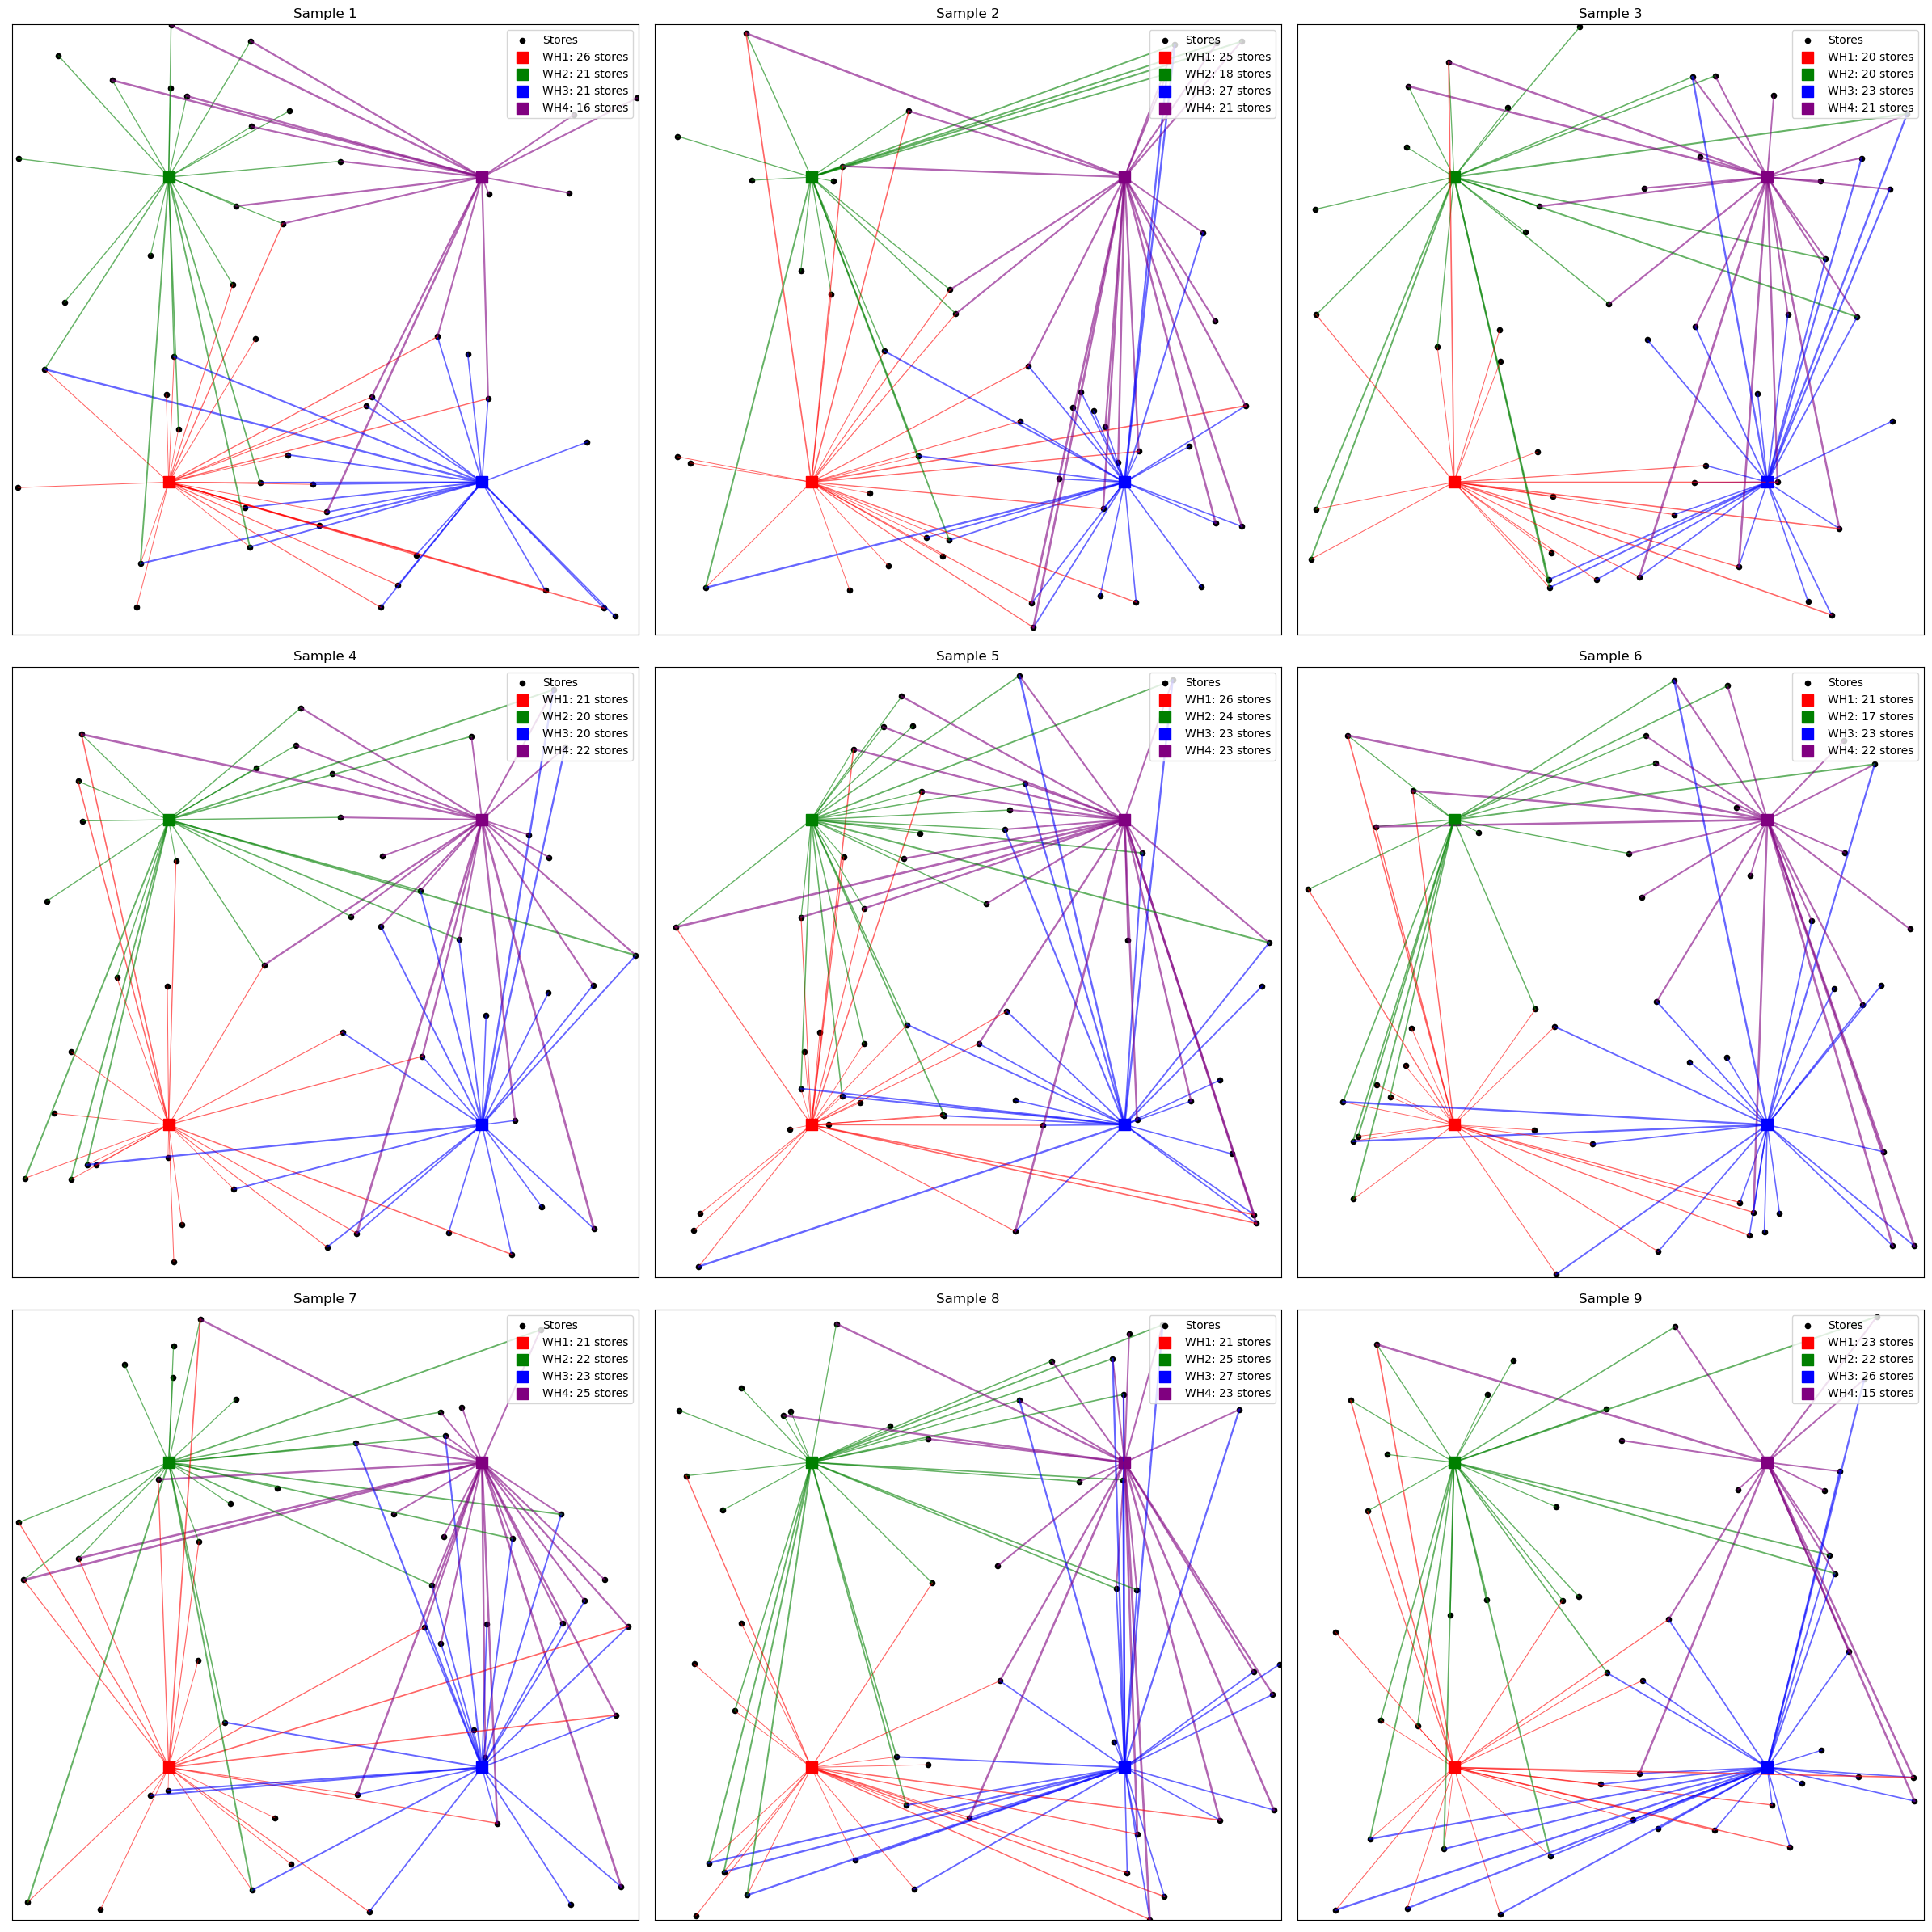

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

# Define parameters
num_stores = 46
num_warehouses = 4
warehouse_locations = np.array([
    [0.25, 0.25], [0.25, 0.75], [0.75, 0.25], [0.75, 0.75]
])

# Sample 9 different configurations
fig, axes = plt.subplots(3, 3, figsize=(24, 24))
axes = axes.ravel()

# Define colors for each warehouse
warehouse_colors = ['red', 'green', 'blue', 'purple']

for plot_idx in range(9):
    # Generate store locations uniformly
    store_locations = np.random.rand(num_stores, 2)
    
    # Fixed warehouse parameters
    additional_lead_time_stores = np.array([1.0, 1.5, 2.0, 2.5])  # Adjust per warehouse
    scaling_factor = 2.0  # To keep lead times reasonable
    
    # Compute distances from warehouses to stores
    distance_matrix = distance.cdist(warehouse_locations, store_locations)
    max_distance = np.max(distance_matrix)
    
    # Compute lead times from each warehouse to each store
    lead_times = additional_lead_time_stores[:, None] + (scaling_factor * distance_matrix / max_distance)
    
    # Connect each store to a random number (2 to 4) of closest warehouses
    connections = []
    warehouse_connections = [0] * num_warehouses  # Count connections per warehouse
    for i in range(num_stores):
        num_connections = np.random.randint(1, 4)  # 2 to 4 connections
        closest_warehouses = np.argsort(distance_matrix[:, i])[:num_connections]
        for w in closest_warehouses:
            connections.append((warehouse_locations[w], store_locations[i], lead_times[w, i], w))
            warehouse_connections[w] += 1
    
    # Set up subplot
    ax = axes[plot_idx]
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Sample {plot_idx + 1}")
    
    # Plot stores
    ax.scatter(store_locations[:, 0], store_locations[:, 1], c='black', label='Stores', s=20)
    
    # Plot warehouses with connection counts in legend
    for w in range(num_warehouses):
        ax.scatter(warehouse_locations[w, 0], warehouse_locations[w, 1], c=warehouse_colors[w],
                  label=f'WH{w+1}: {warehouse_connections[w]} stores', s=100, marker='s')
    
    # Plot connections with thickness based on lead time and color based on warehouse
    for (wh, st, lt, w) in connections:
        ax.plot([wh[0], st[0]], [wh[1], st[1]], color=warehouse_colors[w], alpha=0.6, linewidth=lt/2)
    
    # Add legend inside the plot in upper right
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()